# TensorFlow and Computer Vision - DIY

### Background:

You are now asked to solve another problem based on computer vision. Your task is to identify Sign Language Digits. You will again use the TensorFlow framework to solve the sign identification problem.

### About the dataset
You will use the Sign Language Digits Dataset as a sample dataset. Sign Language Digits Dataset distinguishes the sign language digits from 0–9. The following image shows a sample of the dataset.

![](img/sign-number.png)


This lab is designed based on the aws-samples available in the following [github repo](https://github.com/aws-samples/sagemaker-multi-model-endpoint-tensorflow-computer-vision).

**Note** To run the code cell, press **SHIFT + ENTER**. When the cell finishes running, the text to the left of the cell changes from **In [*]:** to **In [1]**.

### Setup

 #### Prerequisites 
 Update the Sagemaker to the latest version and install the TensorFlow framework 2.6.1.

In [2]:
%%capture
%pip install sagemaker
%pip install tensorflow
%pip install matplotlib

In [3]:
# Validate if the TensorFlow is installed correctly.
import tensorflow as tf
print(f"TensorFlow version:{tf.__version__}")

2024-03-05 23:00:48.646944: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 23:00:48.689606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 23:00:48.689644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 23:00:48.690749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 23:00:48.697255: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 23:00:48.697779: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version:2.15.0


#### Imports 

In [4]:
import os
import time
import boto3
import logging
import sagemaker
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import utils
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sagemaker.tensorflow.serving import TensorFlowModel
from tensorflow.keras.datasets import cifar10

from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Setup Logger

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [6]:
logger.info(f'[Using TensorFlow version: {tf.__version__}]')
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using TensorFlow version: 2.15.0]
[Using SageMaker version: 2.199.0]


#### Seed for Reproducability

In [7]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Create Roles, Sessions and Data Locations

Rememeber to replace **\<Enter_Your_Bucket_Name\>** with the bucket name.

In [8]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.11.0'
BUCKET = 'lab-data-bucket-946847818996-6463bc90'
PREFIX = 'cv-models'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Train Model - Sign Language Image Classification

#### a) Load Data

In [9]:
train_path  = './data/sign_language/train'
validation_path  = './data/sign_language/validation'
test_path  = './data/sign_language/test'

#### b) Data Exploration

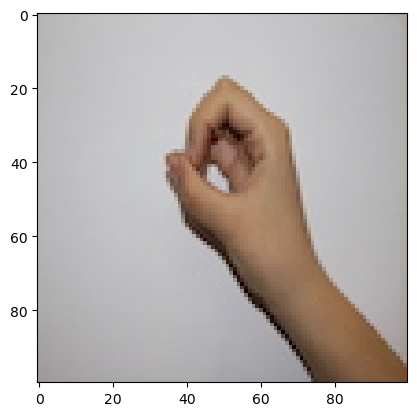

In [10]:
%matplotlib inline
img = mpimg.imread(f'{train_path}/0/IMG_1118.JPG')
plt.imshow(img)

In [11]:
img.shape

(100, 100, 3)

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).

In [12]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1712 images belonging to 10 classes.


In [13]:
train_batches.next()[0][0].shape

(224, 224, 3)

Visualize random sample of images from `train_batches`

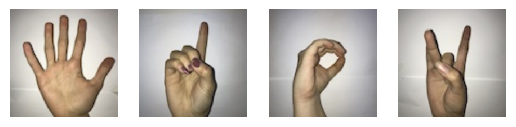

In [14]:
fig, rows = plt.subplots(nrows=1, ncols=4)
for row in rows:
    row.imshow(train_batches.next()[0][0].astype('int'))
    row.axis('off')
plt.show()

#### c) Copy local data to S3 for SageMaker training

In [15]:
!aws s3 cp ./data/sign_language/ s3://{BUCKET}/{PREFIX}/sign_language/ --recursive

upload: data/sign_language/test/0/IMG_4725.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/0/IMG_4725.JPG
upload: data/sign_language/test/0/.ipynb_checkpoints/IMG_4725-checkpoint.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/0/.ipynb_checkpoints/IMG_4725-checkpoint.JPG
upload: data/sign_language/test/0/.ipynb_checkpoints/IMG_4976-checkpoint.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/0/.ipynb_checkpoints/IMG_4976-checkpoint.JPG
upload: data/sign_language/test/0/.ipynb_checkpoints/IMG_4159-checkpoint.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/0/.ipynb_checkpoints/IMG_4159-checkpoint.JPG
upload: data/sign_language/test/0/IMG_5695.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/0/IMG_5695.JPG
upload: data/sign_language/test/1/IMG_5340.JPG to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/test/1/IMG_5340.JP

#### d) Define Model Architecture & create Training Script

In [16]:
!pygmentize sign_language_train.py

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import argparse
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


def parse_args():
    parser = argparse.ArgumentParser() 
    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, defau

#### f) Create a TensorFlow Estimator & fit the Model

Remember to enter **InstanceType** and **epochs**

In [17]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/train', 
                            distribution='ShardedByS3Key')
val_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/validation', 
                          distribution='ShardedByS3Key')

In [19]:
model_name = 'sign-language'
instance_type = 'ml.m5.xlarge'
hyperparameters = {'epochs': 10}

estimator_parameters = {'entry_point':'sign_language_train.py',
                        'instance_type': instance_type,
                        'instance_count': 1,
                        'hyperparameters': hyperparameters,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'output_path': f's3://{BUCKET}/{PREFIX}/sign_language/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py39',
                        'script_mode': True}

estimator = TensorFlow(**estimator_parameters)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [20]:
estimator.fit({'train': train_input, 'val': val_input})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cv-sign-language-2024-03-05-23-03-03-309


Using provided s3_resource
2024-03-05 23:03:03 Starting - Starting the training job...
2024-03-05 23:03:22 Starting - Preparing the instances for training...
2024-03-05 23:04:01 Downloading - Downloading input data...
2024-03-05 23:04:31 Downloading - Downloading the training image......
2024-03-05 23:05:21 Training - Training image download completed. Training in progress..2024-03-05 23:05:28.239595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 23:05:28.344630: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-03-05 23:05:28.344810: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread

### Create an Real time Inference Endpoint

#### a) Copy Trained Models to a common S3 Prefix

In [21]:
tf_model_sign = estimator.model_data
output = f's3://{BUCKET}/{PREFIX}/sign-language.tar.gz'

In [22]:
!aws s3 cp {tf_model_sign} {output}

copy: s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign_language/out/cv-sign-language-2024-03-05-23-03-03-309/output/model.tar.gz to s3://lab-data-bucket-946847818996-6463bc90/cv-models/sign-language.tar.gz


#### b) Essentials

In [23]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2024-03-05-23-12-23'

**IMAGE_URI Format:** image_name='763104351884.dkr.ecr.\<region\>.amazonaws.com/\<framework\>-\<job type\>:\<framework version\>-\<cpu/gpu\>-\<python version\>-ubuntu20.04-v1'

Use following [link](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html) to use TensorFlow with the SageMaker Python SDK.

In [24]:
IMAGE_URI = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-gpu-py38-cu112-ubuntu20.04-v1'
model_data_prefix = f's3://{BUCKET}/{PREFIX}/'

#### c) Define a model using tf_model_sign

In [25]:
tf_model_sign = TensorFlowModel(model_data=output, 
                          role=role, 
                          image_uri=IMAGE_URI)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### d) Deploy a real time Inference Endpoint

In [26]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


instance_type = "ml.m5.xlarge"

predictor = tf_model_sign.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating model with name: tensorflow-inference-2024-03-05-23-12-23-689
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2024-03-05-23-12-24-460
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2024-03-05-23-12-24-460


---------!

### Test Real Time Inference Endpoint

#### a) Test Model-1 CIFAR Image Classification

In [27]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

#### b) Test Sign Language Classification

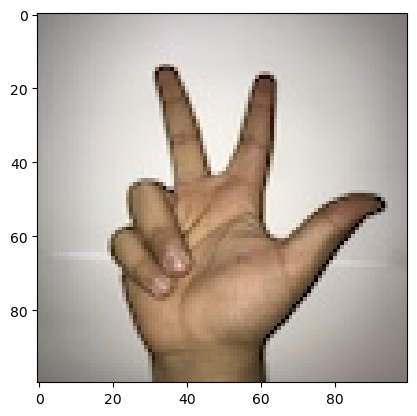

In [28]:
test_path  = './data/sign_language/test'
img = mpimg.imread(f'{test_path}/3/IMG_5114.JPG')
plt.imshow(img)

In [29]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [30]:
data = path_to_tensor(f'{test_path}/3/IMG_5114.JPG')
payload = {'instances': data}

In [31]:
y_pred = predictor.predict(data=payload)

In [32]:
predicted_label = np.argmax(y_pred['predictions'])
print(f'Predicted Label: [{predicted_label}]')

Predicted Label: [5]


In [33]:
y_pred

{'predictions': [[0.0996862277,
   0.100673176,
   0.100684181,
   0.10056977,
   0.0996914059,
   0.101136662,
   0.100428224,
   0.0991986394,
   0.099041976,
   0.0988897681]]}

In [34]:
np.argmax(y_pred['predictions'])

5

## Cleanup (Optional)

Uncomment the below code block to delete the Sagemaker Endpoint.

In [ ]:
#predictor.delete_endpoint()